# ISM algorithm

This jupyter notebook contains the python version of one of the researched and implemented algorithms in my degree project called the Image Source Method (ISM) (Version: Viveiros & Gibbs). This algorihm is used for calculating an IR (Impulse Response) of a rectangular-shaped virtual room, using room acoustics parameters. Afterwards, this IR is used to get the reverberation effect on any audio signal.

For the record, the code inside the ISM() function, is entirely based on the MATLAB version that can be found on the 'ISM_dis.m' file.

In [3]:
# numpy and matplotlib namespace
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [44]:
# The thinkdsp module (from A. Downey) is required
import thinkdsp
# Interactive audio playback
from IPython.display import Audio

# ISM function

For contextualization purposes, an IR can be defined as the energy behaviour representation of a short-duration piece of sound (a clap, a gunshot) inside a room along time, from its emission moment to total silence. 
In signal processing terms, the IR characterizes the sound transformation when it is emitted by a source inside a room. In artistic terms, the IR is a tool used to get the reverberation effect, using convolution.

This function calculates the IR according to the given parameters. Each of the parameters was intended to be named as intuitive as possible.   

In [45]:
# This algorithm is based on a previous made one but on MATLAB, the framework I used to develop the coding
# section of my degree project ('ISM_dis.m'). Translating it to Python wasn't very hard, just changing some MATLAB 
# symbols such as 'ˆ' or power, or '.' for element-wise operations, to its corresponding functions in Python. 
# Fortunately, element wise operations (*, +) are automatically done in Python just by using numpy arrays instead
# of primitive lists.

def ISM(sourc_x,sourc_y,sourc_z,mic_x,mic_y,mic_z,width,large,heigh,Fs):
    cSound = 340
    # Air damping coefficient
    airDamp = 0.005
    # Number of reflections per axis
    N = float(30)
    n = arange(-N,N)
    l,m,n = meshgrid( n,n,n )
    # Absorption coefficients per surface
    coefabsor_x1 = 0.62 
    coefabsor_x2 = 0.62 
    coefabsor_y1 = 0.63 
    coefabsor_y2 = 0.85 
    coefabsor_z1 = 0.68 
    coefabsor_z2 = 0.99 
    coefAbsor = array( [coefabsor_x1,coefabsor_x2,coefabsor_y1,coefabsor_y2,coefabsor_z1,coefabsor_z2] )

    # IR obtention procedures

    # Image cell coordinates 
    dx = ( (width*l)  + ( power(-1,l) * sourc_x ) ) - mic_x
    dy = ( (large*m)  + ( power(-1,m) * sourc_y ) ) - mic_y
    dz = ( (heigh*n) + ( power(-1,n) * sourc_z ) ) - mic_z
    # Distances from image cell to listener
    Dlmn = sqrt( power(dx,2) + power(dy,2) + power(dz,2) )
    # Room absorption function per axis
    coefAbsor = -1 * abs(coefAbsor)
    absorFunc_x = power(coefAbsor[0],abs(0.5*l - 0.25 + 0.25*power(-1,l))) + \
                  power(coefAbsor[1],abs(0.5*l + 0.25 - 0.25*power(-1,l)))
    absorFunc_y = power(coefAbsor[2],abs(0.5*m - 0.25 + 0.25*power(-1,m))) + \
                  power(coefAbsor[3],abs(0.5*m + 0.25 - 0.25*power(-1,m)))
    absorFunc_z = power(coefAbsor[4],abs(0.5*n - 0.25 + 0.25*power(-1,n))) + \
                  power(coefAbsor[5],abs(0.5*n + 0.25 - 0.25*power(-1,n)))
    absorFunc = absorFunc_x * absorFunc_y * absorFunc_z        
    # Air damping function
    airDampFunc = exp(-airDamp * Dlmn)
    # Damping coefficient
    P = divide(1,Dlmn) * absorFunc * airDampFunc
    # Delays due to distance (in other words, sample-based times that correspond each to a damping coefficient)
    realTime = divide(Dlmn,cSound)
    # In this line, 'numpy.round' had to be typed instead of just traditional 'round'
    nSample = numpy.round(realTime*Fs)
    nSam = reshape(nSample,(1,nSample.size))
    # Cast from rounded float to int in order to correctly index the IR array
    nS = nSam.astype(int)

    # IR obtention
    
    # IR vector initialization
    IR = zeros(nS.size)
    # Assigning sample-based times to damping coefficients
    IR[nS] = reshape(P,(1,P.size))
    # IR normalization
    IR = IR / abs(IR.max()) 
    return IR

# Processing an audio signal

As said on the first cell, an audio signal is processed with the IR (via convolution) in order to get reverberation effect. 

In [46]:
# First, read any audio file (it must be on the same notebook folder)
audio = thinkdsp.read_wave('ElecGtr.wav')

# Get the IR
ir = ISM(7,2,3,-1,-5,-2,20,10,10,audio.framerate)

# Preparing convolution variables
# Audio signal length
L = len(audio.ys)
# IR length
N = len(ir)
M = L + N - 1
# (Fast) Convolution process (frequency domain)
wetSig = np.fft.ifft( (np.fft.fft(audio.ys,M) * np.fft.fft(ir,M)) )

# Before listening...

the IR will be visualized.

Text(0,0.5,'Sound pressure')

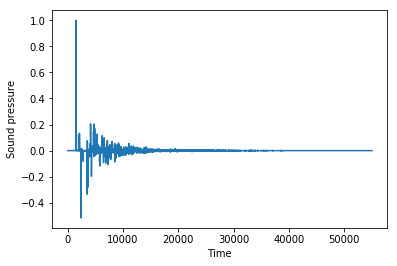

In [47]:
fig,ax = subplots()
ax.plot(ir[:55000])
ax.set_xlabel('Time')
ax.set_ylabel('Sound pressure')

# Listening the original and processed signals

In [48]:
# Recall the audio object that contains the original signal
Audio(data=audio.ys,rate=audio.framerate)

# Take a listen to the original signal

In [49]:
# Now, in order to listen the processed signal (wetSig), some modifications shall be done, because wetSig is 
# still a numpy.ndarray

# Transform into a wave object
wS = thinkdsp.Wave(ys=wetSig,framerate=audio.framerate)
wS.make_audio()
# Sort of fades in and out the sound
wS.apodize()
Audio(data=wS.ys,rate=audio.framerate)

# Now, listen to the processed signal